<a href="https://colab.research.google.com/github/arghyadeep-dev/BABYWHITE/blob/master/mnist_cnn_grid_search_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>This project is on Digit recognition.....
I have taken mnist dataset and used grid search for hyperparameter tyning and ImageDataGenerator For Data Augmentation</h1>

In [7]:
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# keras import
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# hyperparameter optimization
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# data augmentation
from keras.preprocessing.image import ImageDataGenerator

# visualisation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
#set figure size
plt.rcParams['figure.figsize'] = 12, 6
sns.set_style('white')

# others
from random import randrange
from time import time

I define here global constants for the number of epochs when training an individual model (n_epochs) or doing a grid search with cross validation (n_epochs_cv). Reduce these 2 values if you want to reduce the running time of the kernel.  

I also define the number of runs for cross validation (when using Scikit Learn GridSearchCV) and the size of the validation set for train_test_split.


In [ ]:
n_epochs = 30 # 30 
n_epochs_cv = 10 # 10  # reduce number of epochs for cross validation for performance reason

n_cv = 3
validation_ratio = 0.10


## 1. EDA: initial look at the data
We load the data and display some sample observations to understand the data.....DATASET is taken from kaggle structure.  

In [2]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission (1).csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [8]:
# load dataset and check dimension
data_set = pd.read_csv('/content/train.csv')
print(data_set.shape)

(42000, 785)


In [ ]:
data_set.sample(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
9719,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11004,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6936,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We check the distribution of the 10 classes of digits. They are roughly equivalently represented, therefore we do not need to use stratify when splitting the data set into training and validation sets.

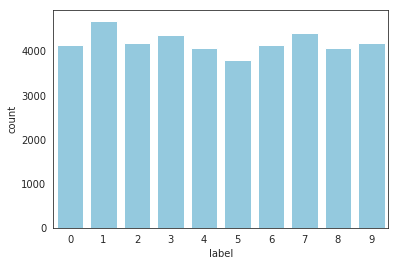

In [ ]:
# segregate training data set in pixel features and label
y = data_set['label']
X = data_set.drop(labels = ['label'], axis=1) 
# free memory
del data_set

# check distribution of the handwritten digits
sns.countplot(y, color='skyblue');

Next, let's plot a random sample of 60 images to get a *visual feeling* of the classification task. 

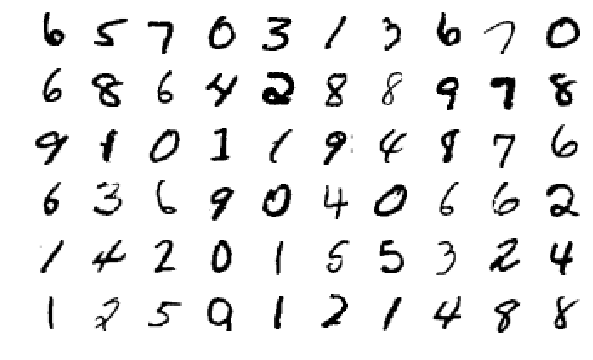

In [ ]:
# show multiple images chosen randomly 
fig, axs = plt.subplots(6, 10, figsize=(10, 6)) # 6 rows of 10 images

for ax in axs.flat:
    i = randrange(X.shape[0])
    ax.imshow(X.loc[i].values.reshape(28, 28), cmap='gray_r')
    ax.set_axis_off()

In [ ]:
# Normalize pixel value to range 0 to 1
X = X / 255.0

# extract train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = validation_ratio)

## 2. Implementing a simple MLP
Let's start with a simple multilayer perceptron with only 1 hidden layer:
* the input layer consists in 128 units, with relu
* the hidden layer is made of 64 units, with sigmoid activation function
* the output layer contains one unit per expected class, that is 10 units, and uses a softmax activation function to output probabilities  
[](http://)
How many parameters has this model?
* the input layer is taking values from 28x28 images: the number of parameters is 28x28 (input size) x 128 (output size) weights + 128 bias values = 100,480
* for the hidden layer, a similar caculation gives 128 x 64 + 64 = 8,256
* and for the output layer, we have 64 x 10 + 10 = 650 parameters  

OK, this was easy, but we'll see below that counting parameters of CNN is a bit more tricky. 

In [ ]:
# define model
mlp = Sequential()
mlp.add(Dense(128, activation='relu', input_shape=(784,)))
mlp.add(Dense(64, activation='sigmoid'))  
mlp.add(Dense(10, activation='softmax'))

mlp.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

mlp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


Now, let's train the model. I am using a early stop callback to reduce training time.  
Look at the accuracy on the validation set and compare it with the accuracy on the training set. What can you say about the performance and limits of this simple model?

In [ ]:
# Train the model

#define callbacks
early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, restore_best_weights=True)

history = mlp.fit(
    X_train,
    to_categorical(y_train),
    epochs = n_epochs,  
    validation_data = (X_val, to_categorical(y_val)),
    batch_size = 32,
    callbacks = [early_stop]
)

Train on 37800 samples, validate on 4200 samples
Epoch 1/30
37800/37800 [==============================] - 5s 125us/step - loss: 0.3952 - accuracy: 0.8972 - val_loss: 0.1988 - val_accuracy: 0.9410
Epoch 2/30
37800/37800 [==============================] - 4s 113us/step - loss: 0.1479 - accuracy: 0.9576 - val_loss: 0.1370 - val_accuracy: 0.9590
Epoch 3/30
37800/37800 [==============================] - 4s 116us/step - loss: 0.0994 - accuracy: 0.9702 - val_loss: 0.1170 - val_accuracy: 0.9631
Epoch 4/30
37800/37800 [==============================] - 4s 112us/step - loss: 0.0725 - accuracy: 0.9778 - val_loss: 0.1088 - val_accuracy: 0.9688
Epoch 5/30
37800/37800 [==============================] - 4s 115us/step - loss: 0.0545 - accuracy: 0.9837 - val_loss: 0.0952 - val_accuracy: 0.9726
Epoch 6/30
37800/37800 [==============================] - 4s 114us/step - loss: 0.0414 - accuracy: 0.9877 - val_loss: 0.0984 - val_accuracy: 0.9683
Epoch 7/30
37800/37800 [==============================] - 4s 11

## What can we say from the results of our training:
* the performance of our model is given by the best accuracy obtained on the validation set: around 0.975 (depending on the run)
* the best scores are already obtained after more or less 10 epochs, meaning that there is probably no or little gain to increase number of epochs
* and there is clear sign of overfitting as the loss for the validation set (around 0.1) is roughly 10 times the loss on the training set (around 0.01).  

Let's plot the accuracy for the training and validation to confirm this last point.  

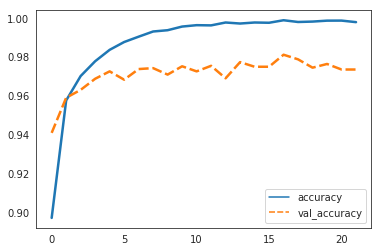

In [ ]:
# compare accuracy accuracy on training and validation data
df_history = pd.DataFrame(history.history)
sns.lineplot(data=df_history[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5);

## 3. Optimize hyperparameters and add dropout to reduce overfit
As our MLP model shows sign of overfit, we will now add dropout layers to try to fix this. The dropout rate will be determined thru a grid search, along with the batch size.  
For this, we will use the KerasClassifier wrapper for Scikit Learn, which gives us a Scikit Learn estimator that we can optimize with GridSearchCV 

Results are:
* no more overfit from dropout rate = 0.2 and above 
* no or minimal improvement of the accuracy on the validation set: **we are reaching the limit of a simple MLP model**
* noticeable degradation of results (both on training and validation sets) for rate of 0.4 and above 

In [ ]:
start=time()

# define a function to create model, required for KerasClassifier
# the function takes drop_out rate as argument so we can optimize it  
def create_mlp_model(dropout_rate=0):
    # create model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(784,))) 
    # add a dropout layer if rate is not null
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))        
    model.add(Dense(64, activation='sigmoid')) 
    # add a dropout layer if rate is not null    
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))           
    model.add(Dense(10, activation='softmax'))
    
    # Compile model
    model.compile( 
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )    
    return model

# define function to display the results of the grid search
def display_cv_results(search_results):
    print('Best score = {:.4f} using {}'.format(search_results.best_score_, search_results.best_params_))
    means = search_results.cv_results_['mean_test_score']
    stds = search_results.cv_results_['std_test_score']
    params = search_results.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print('mean test accuracy +/- std = {:.4f} +/- {:.4f} with: {}'.format(mean, stdev, param))    
    
# create model
model = KerasClassifier(build_fn=create_mlp_model, verbose=1)
# define parameters and values for grid search 
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [n_epochs_cv],
    'dropout_rate': [0.0, 0.10, 0.20, 0.30],
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=n_cv)
grid_result = grid.fit(X, to_categorical(y))  # fit the full dataset as we are using cross validation 

# print out results
print('time for grid search = {:.0f} sec'.format(time()-start))
display_cv_results(grid_result)

Epoch 1/10
42000/42000 [==============================] - 8s 189us/step - loss: 0.3691 - accuracy: 0.8981
Epoch 2/10
42000/42000 [==============================] - 8s 180us/step - loss: 0.1501 - accuracy: 0.9550
Epoch 3/10
42000/42000 [==============================] - 8s 182us/step - loss: 0.1073 - accuracy: 0.9688
Epoch 4/10
42000/42000 [==============================] - 8s 185us/step - loss: 0.0835 - accuracy: 0.9743
Epoch 5/10
42000/42000 [==============================] - 8s 186us/step - loss: 0.0685 - accuracy: 0.9789
Epoch 6/10
42000/42000 [==============================] - 8s 187us/step - loss: 0.0584 - accuracy: 0.9817
Epoch 7/10
42000/42000 [==============================] - 8s 185us/step - loss: 0.0503 - accuracy: 0.9838
Epoch 8/10
42000/42000 [==============================] - 8s 191us/step - loss: 0.0443 - accuracy: 0.9858
Epoch 9/10
42000/42000 [==============================] - 9s 204us/step - loss: 0.0402 - accuracy: 0.9863
Epoch 10/10
42000/42000 [=====================

In [ ]:
# reload best model
mlp = grid_result.best_estimator_ 

# retrain best model on the full training set 
history = mlp.fit(
    X_train,
    to_categorical(y_train),
    validation_data = (X_val, to_categorical(y_val)),
    epochs = n_epochs,
    callbacks = [early_stop]    
)

Train on 37800 samples, validate on 4200 samples
Epoch 1/30
37800/37800 [==============================] - 8s 210us/step - loss: 0.3694 - accuracy: 0.8984 - val_loss: 0.1831 - val_accuracy: 0.9436
Epoch 2/30
37800/37800 [==============================] - 7s 198us/step - loss: 0.1503 - accuracy: 0.9558 - val_loss: 0.1284 - val_accuracy: 0.9595
Epoch 3/30
37800/37800 [==============================] - 8s 199us/step - loss: 0.1078 - accuracy: 0.9668 - val_loss: 0.1078 - val_accuracy: 0.9695
Epoch 4/30
37800/37800 [==============================] - 8s 202us/step - loss: 0.0860 - accuracy: 0.9738 - val_loss: 0.0989 - val_accuracy: 0.9686
Epoch 5/30
37800/37800 [==============================] - 8s 203us/step - loss: 0.0694 - accuracy: 0.9790 - val_loss: 0.0996 - val_accuracy: 0.9707
Epoch 6/30
37800/37800 [==============================] - 8s 201us/step - loss: 0.0601 - accuracy: 0.9808 - val_loss: 0.0970 - val_accuracy: 0.9721
Epoch 7/30
37800/37800 [==============================] - 7s 19

4200/4200 [==============================] - 0s 52us/step
Accuracy on validation data = 0.9771


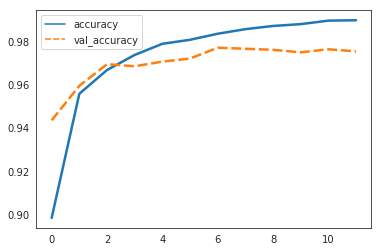

In [ ]:
# get prediction on validation dataset 
y_pred = mlp.predict(X_val)
print('Accuracy on validation data = {:.4f}'.format(accuracy_score(y_val, y_pred)))

# plot accuracy on training and validation data
df_history = pd.DataFrame(history.history)
sns.lineplot(data=df_history[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5);

In [13]:
# load test data and make prediction
test = pd.read_csv('/content/test.csv')
y_test = mlp.predict(test)

ParserError: ignored

In [ ]:
# convert prediction to df
submission = pd.DataFrame(data=y_test)

# set label as the 0-9 class with highest value 
submission['Label'] = submission.idxmax(axis=1)
submission['ImageId'] = np.asarray([i+1 for i in range(submission.shape[0])])

submission.to_csv('submission-mlp_dropout.csv', 
                  columns=['ImageId','Label'],
                  header=True,
                  index=False)


## 4. Implementing a Convolutional Neural Network
We implement now a CNN since MLP model is limited at 0.975 accuracy. I selected the architecture thru trials based on several examples. 

In [ ]:
# Reshape the images
img_size = 28
X_cnn = X.values.reshape(-1, img_size, img_size, 1)
# check 
print(X_cnn.shape)

X_train, X_val, y_train, y_val = train_test_split(X_cnn, y, test_size = validation_ratio)

(42000, 28, 28, 1)


In [ ]:
# function to create the model for Keras wrapper to scikit learn
# we will optimize the type of pooling layer (max or average) and the activation function of the 2nd and 3rd convolution layers 
def create_cnn_model(pool_type='max', conv_activation='sigmoid', dropout_rate=0.10):
    # create model
    model = Sequential()
    
    # first layer: convolution
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1))) 
        
    # second series of layers: convolution, pooling, and dropout
    model.add(Conv2D(32, kernel_size=(5, 5), activation=conv_activation))  
    if pool_type == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if pool_type == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2)))
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))     
    
    # third series of layers: convolution, pooling, and dropout    
    model.add(Conv2D(64, kernel_size=(3, 3), activation=conv_activation))   # 32   
    if pool_type == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if pool_type == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2)))
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))     
      
    # fourth series
    model.add(Flatten())         
    model.add(Dense(64, activation='sigmoid')) # 64
    # add a dropout layer if rate is not null    
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate)) 
        
    model.add(Dense(10, activation='softmax'))
    
    # Compile model
    model.compile( 
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )    
    return model

cnn = create_cnn_model()

cnn.compile(
  optimizer='adam',
  loss='categorical_crossentropy',  
  metrics=['accuracy'],
)

cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 16)        416       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 64)         

********************************************************************************
Let's check the number of parameters:
* the first layer is a convolution layer with 16 kernels of size 5x5. Each kernel has 26 parameters (25 weigths plus bias). Total is 16 x 26 = 416
* the second layer is also a convolution layer with 32 kernels of size 5x5. There are 16 input images from the output of the previous layer. For every kernel, the 16 images are combined together, with 16 (input size) x 25 (kernel size) weights plus bias (that is 401 parameters for each kernel). Total number of parameters for this layers is 401 x 32 = 12,832
* using same calculation logic, the number of parameters for the 3rd layer is ( 32 (input size) x 9 (kernel size) + 1 ) x 64 (number of kernels) = 18,4896
* for the dense layer, its input is the result of the flatten layer (taking as input the 64 x 16 images from the pooling layer, and mapping them to a flat array of 64 x 16 = 1024). Output size is 64, therefore number of parameters is 64 x (1024 weights + bias) = 65,600
* same way, the final layer has (64 x 1) x 10 = 650 parameters
********************************************************************************

In [ ]:
# Train the default CNN model
history = cnn.fit(
    X_train,
    to_categorical(y_train),
    epochs=n_epochs,  
    validation_data=(X_val, to_categorical(y_val)), 
    batch_size=32,
    callbacks = [early_stop]
)

Train on 37800 samples, validate on 4200 samples
Epoch 1/30
37800/37800 [==============================] - 40s 1ms/step - loss: 0.5140 - accuracy: 0.8495 - val_loss: 0.1221 - val_accuracy: 0.9669
Epoch 2/30
37800/37800 [==============================] - 39s 1ms/step - loss: 0.1081 - accuracy: 0.9702 - val_loss: 0.0794 - val_accuracy: 0.9788
Epoch 3/30
37800/37800 [==============================] - 40s 1ms/step - loss: 0.0757 - accuracy: 0.9784 - val_loss: 0.0607 - val_accuracy: 0.9814
Epoch 4/30
37800/37800 [==============================] - 41s 1ms/step - loss: 0.0576 - accuracy: 0.9832 - val_loss: 0.0526 - val_accuracy: 0.9838
Epoch 5/30
37800/37800 [==============================] - 40s 1ms/step - loss: 0.0495 - accuracy: 0.9854 - val_loss: 0.0484 - val_accuracy: 0.9848
Epoch 6/30
37800/37800 [==============================] - 40s 1ms/step - loss: 0.0408 - accuracy: 0.9874 - val_loss: 0.0421 - val_accuracy: 0.9857
Epoch 7/30
37800/37800 [==============================] - 40s 1ms/ste

*************************************************************

## 5. Optimize the hyperparameters of the CNN thru GridSearch

In [ ]:
# optimize model 
start = time()

# create model
model = KerasClassifier(build_fn=create_cnn_model, verbose=1)
# define parameters and values for grid search 
param_grid = {
    'pool_type': ['max', 'average'],
    'conv_activation': ['sigmoid', 'tanh'],    
    'epochs': [n_epochs_cv],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=n_cv)
grid_result = grid.fit(X_train, to_categorical(y_train))

# summarize results
print('time for grid search = {:.0f} sec'.format(time()-start))
display_cv_results(grid_result)

Epoch 1/10
37800/37800 [==============================] - 39s 1ms/step - loss: 0.2464 - accuracy: 0.9382
Epoch 2/10
37800/37800 [==============================] - 39s 1ms/step - loss: 0.0682 - accuracy: 0.9818
Epoch 3/10
37800/37800 [==============================] - 38s 1ms/step - loss: 0.0495 - accuracy: 0.9861
Epoch 4/10
37800/37800 [==============================] - 38s 1ms/step - loss: 0.0414 - accuracy: 0.9878
Epoch 5/10
37800/37800 [==============================] - 38s 1ms/step - loss: 0.0351 - accuracy: 0.9888
Epoch 6/10
37800/37800 [==============================] - 39s 1ms/step - loss: 0.0292 - accuracy: 0.9912
Epoch 7/10
37800/37800 [==============================] - 38s 1ms/step - loss: 0.0268 - accuracy: 0.9919
Epoch 8/10
37800/37800 [==============================] - 39s 1ms/step - loss: 0.0235 - accuracy: 0.9934
Epoch 9/10
37800/37800 [==============================] - 39s 1ms/step - loss: 0.0217 - accuracy: 0.9929
Epoch 10/10
37800/37800 [==============================

## 6. Use data augmentation to improve performance

Epoch 1/30
1182/1181 [==============================] - 45s 38ms/step - loss: 0.4844 - accuracy: 0.8635 - val_loss: 0.0923 - val_accuracy: 0.9745
Epoch 2/30
1182/1181 [==============================] - 45s 38ms/step - loss: 0.1716 - accuracy: 0.9505 - val_loss: 0.0549 - val_accuracy: 0.9826
Epoch 3/30
1182/1181 [==============================] - 45s 38ms/step - loss: 0.1333 - accuracy: 0.9599 - val_loss: 0.0508 - val_accuracy: 0.9836
Epoch 4/30
1182/1181 [==============================] - 44s 38ms/step - loss: 0.1171 - accuracy: 0.9647 - val_loss: 0.0477 - val_accuracy: 0.9848
Epoch 5/30
1182/1181 [==============================] - 44s 37ms/step - loss: 0.1058 - accuracy: 0.9686 - val_loss: 0.0460 - val_accuracy: 0.9852
Epoch 6/30
1182/1181 [==============================] - 44s 37ms/step - loss: 0.0973 - accuracy: 0.9709 - val_loss: 0.0414 - val_accuracy: 0.9879
Epoch 7/30
1182/1181 [==============================] - 45s 38ms/step - loss: 0.0921 - accuracy: 0.9719 - val_loss: 0.0414 -

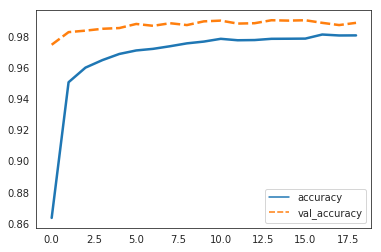

In [ ]:
# optimize parameters of the fit method 
cnn_model = create_cnn_model(pool_type = grid_result.best_params_['pool_type'],
                             conv_activation = grid_result.best_params_['conv_activation'])

# With data augmentation 
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        fill_mode='constant', cval = 0.0)

datagen.fit(X_train)

history = cnn_model.fit_generator(datagen.flow(X_train,to_categorical(y_train), batch_size=32),
                                  epochs = n_epochs, 
                                  validation_data = (X_val,to_categorical(y_val)),
                                  verbose = 1, 
                                  steps_per_epoch = X_train.shape[0] / 32,
                                  callbacks = [early_stop])

# plot accuracy on training and validation data
df_history = pd.DataFrame(history.history)
sns.lineplot(data=df_history[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5);

##Data Augmentation By ImageDataGenerator

In [ ]:
# optimize parameters of the fit method 
cnn_model = create_cnn_model(pool_type = grid_result.best_params_['pool_type'],
                             conv_activation = grid_result.best_params_['conv_activation'], 
                            dropout_rate=0.0)

#define early stop on the accuracy as this is the metric we want to improve
early_stop = EarlyStopping(monitor = 'accuracy', mode = 'max', patience=5, restore_best_weights=True)
history = cnn_model.fit_generator(datagen.flow(X_train,to_categorical(y_train), batch_size=32),
                                  epochs = n_epochs, 
                                  validation_data = (X_val,to_categorical(y_val)),
                                  verbose = 1, 
                                  steps_per_epoch = X_train.shape[0] / 32,
                                  callbacks = [early_stop])

# plot accuracy on training and validation data
df_history = pd.DataFrame(history.history)
sns.lineplot(data=df_history[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5);

Epoch 1/30
1182/1181 [==============================] - 43s 36ms/step - loss: 0.4572 - accuracy: 0.8753 - val_loss: 0.0847 - val_accuracy: 0.9798
Epoch 2/30
1182/1181 [==============================] - 42s 36ms/step - loss: 0.1372 - accuracy: 0.9610 - val_loss: 0.0568 - val_accuracy: 0.9845
Epoch 3/30
1182/1181 [==============================] - 43s 36ms/step - loss: 0.1088 - accuracy: 0.9679 - val_loss: 0.0520 - val_accuracy: 0.9833
Epoch 4/30
1182/1181 [==============================] - 42s 36ms/step - loss: 0.0888 - accuracy: 0.9743 - val_loss: 0.0536 - val_accuracy: 0.9845
Epoch 5/30
1182/1181 [==============================] - 42s 36ms/step - loss: 0.0802 - accuracy: 0.9757 - val_loss: 0.0468 - val_accuracy: 0.9862
Epoch 6/30
1182/1181 [==============================] - 42s 36ms/step - loss: 0.0738 - accuracy: 0.9781 - val_loss: 0.0398 - val_accuracy: 0.9867
Epoch 7/30
1182/1181 [==============================] - 43s 37ms/step - loss: 0.0685 - accuracy: 0.9792 - val_loss: 0.0417 -

# ***##So here is our project on Digit recognition.We optimised the code by hyperparameter tuning- GRID SEARCH METHOD and Data augmentation by ImageDataGenerator***

 Project submitted by Arghyadeep Dhar *BT18CSE105* and Rohan Patil *BT18CSE022*